In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

import astropy.units as u
import matplotlib as mpl
import sys 
sys.path.append("../../")
from plot_OpSims import plot_OpSims_Nqso_hist_v2

In [3]:
# import maf python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [4]:
# import convenience functions
import sys 
sys.path.append("../../../LSST_OpSim")
from Scripts_NBs.opsimUtils import *

In [5]:
NSIDE=64
your_username = "rjassef"
folder_mafoutput = "EM5_{0:d}_v2".format(NSIDE)
resultDbPath = '/home/idies/workspace/Temporary/{0}/scratch/MAFOutput/{1}'.format(
    your_username, folder_mafoutput)
metricDataPath = '/home/idies/workspace/Temporary/{0}/scratch/MAFOutput/{1}/MetricData/'.format(
    your_username, folder_mafoutput)

In [6]:
# get a dictionary of resultDb from given directory
resultDbs = getResultsDbs(resultDbPath)

In [7]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts_raw = dict()
for runName in resultDbs:
    bundleDicts_raw[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [8]:
#Rearrange the bundleDicts_raw dictionary so that the keys are always the same as for the first run.
dbRuns = list(bundleDicts_raw.keys())
Keys = list(bundleDicts_raw[dbRuns[0]].keys())
bundleDicts = dict()
for runName in dbRuns:
    bundleDicts[runName] = dict()
    Keys_raw = bundleDicts_raw[runName]
    for Key in Keys:
        for Key_raw in Keys_raw:
            if Key[1]==Key_raw[1]:
                bundleDicts[runName][Key] = bundleDicts_raw[runName][Key_raw]

In [9]:
# check keys
dbRuns = list(resultDbs.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'EM5_i')]


In [10]:
#Make sure that the plots folder exists.
plots_folder = "plots_all_opsims_{0:d}".format(NSIDE)
if not os.path.exists(plots_folder):
    os.mkdir(plots_folder)

In [11]:
sys.path.append("../../Filter_Curves/")
from lam_eff import lam_eff

In [12]:
sys.path.append("../")
from Fast_Nqso import Fast_Nqso

In [13]:
#filters = ["u","g","r","i","z","y"]
filters = ["i"]
mbright = {"u":14.7,
           "g":15.7,
           "r":15.8,
           "i":15.8,
           "z":15.3,
           "y":13.9
          }
Nqso = dict()
Area = dict()
dens = dict()
for filter in filters:
    zmin = 0.3
    zmax = np.min([6.7, (lam_eff['LSST'+filter]/(912.*u.AA)).to(1.).value])
    for k, run in enumerate(dbRuns):
        for run_key in bundleDicts[run].keys():
            if run_key[1][-1]==filter:
                Key = run_key
                break
        mask  = bundleDicts[run][Key].metricValues.mask
        mlim5 = bundleDicts[run][Key].metricValues[~mask]
        filter = Key[1][-1]
        qso_counter = Fast_Nqso("LSST"+filter,"Shen20","A",
                                area=bundleDicts[run][Key].slicer.pixArea*u.sr)
        if filter not in Nqso:
            Nqso[filter] = np.zeros(len(dbRuns))
            Area[filter] = np.zeros(len(dbRuns))
            dens[filter] = np.zeros(len(dbRuns))
        Nqso[filter][k] = np.sum(qso_counter.Nqso(zmin, zmax, mbright[filter], mlim5))
        Area[filter][k] = len(mlim5) * (bundleDicts[run][Key].slicer.pixArea*u.sr).to(u.deg**2).value
        dens[filter][k] = Nqso[filter][k]/Area[filter][k]

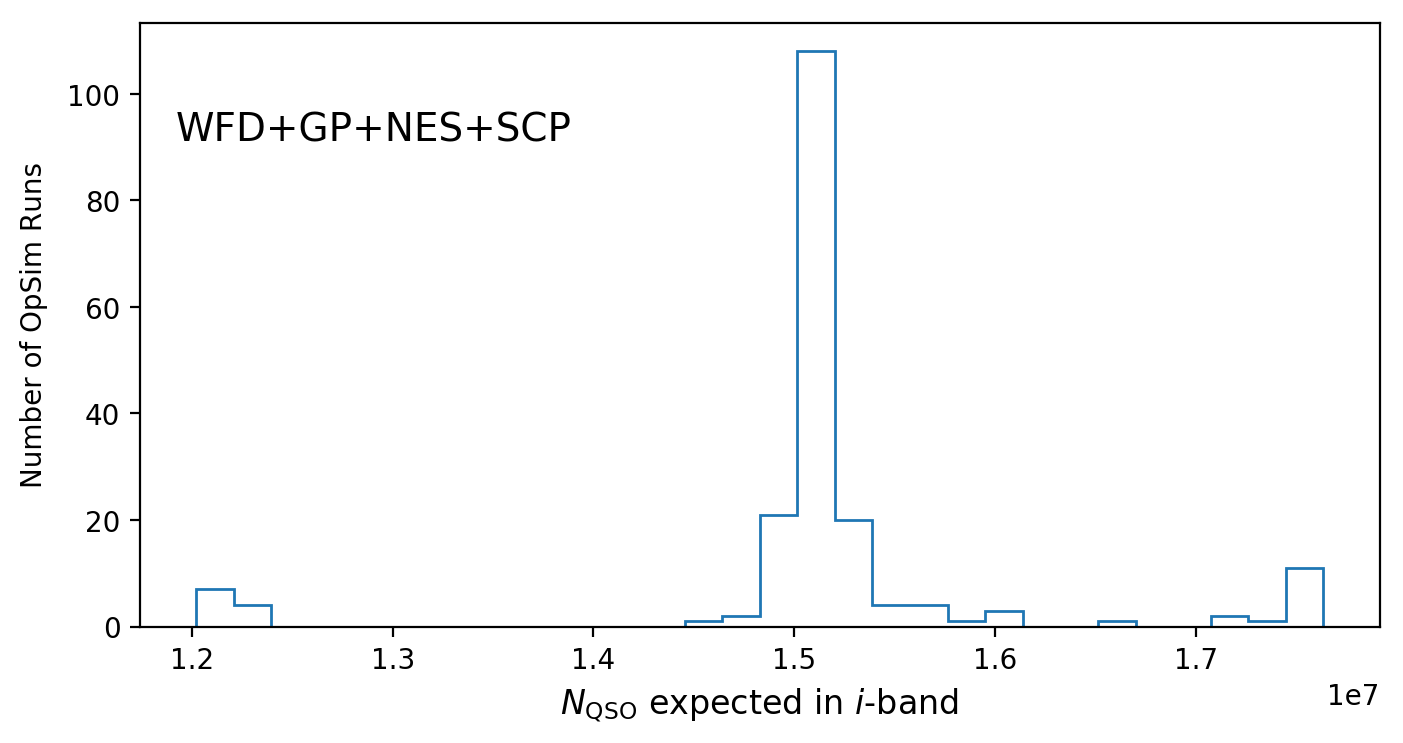

In [14]:
for filter in filters:
    xlabel = r'$N_{\rm QSO}$ expected in $'+filter+r'$-band'
    survey_label = "WFD+GP+NES+SCP"
    plot_OpSims_Nqso_hist_v2(filter, Nqso, xlabel=xlabel, 
                             datamin=None, datamax=None, bins=30, figsize=(8,4),
                             survey_label=survey_label)
    plt.savefig(plots_folder+"/Nqso_{}.png".format(filter))

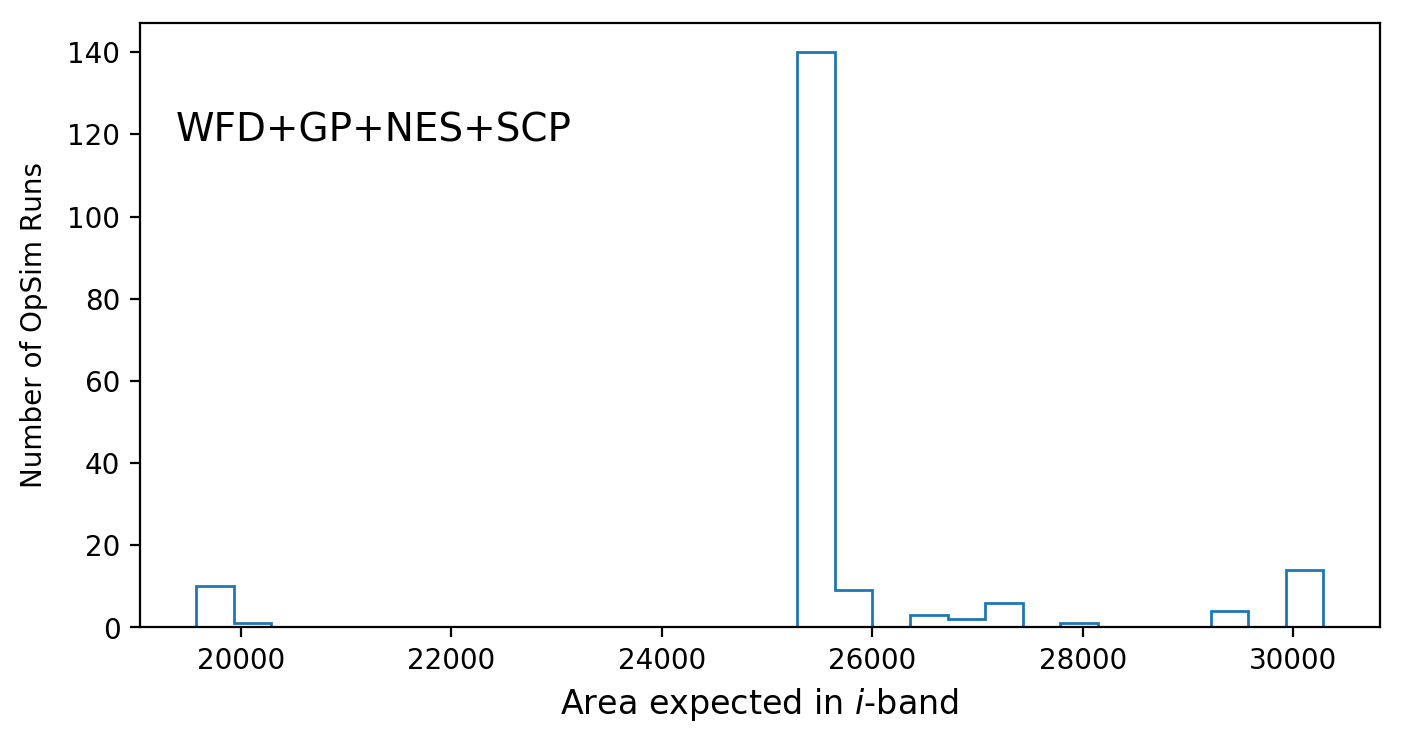

In [15]:
for filter in filters:
    xlabel = r'Area expected in $'+filter+r'$-band'
    survey_label = "WFD+GP+NES+SCP"
    plot_OpSims_Nqso_hist_v2(filter, Area, xlabel=xlabel, 
                             datamin=None, datamax=None, bins=30, figsize=(8,4), 
                             survey_label=survey_label)
    plt.savefig(plots_folder+"/Area_{}.png".format(filter))

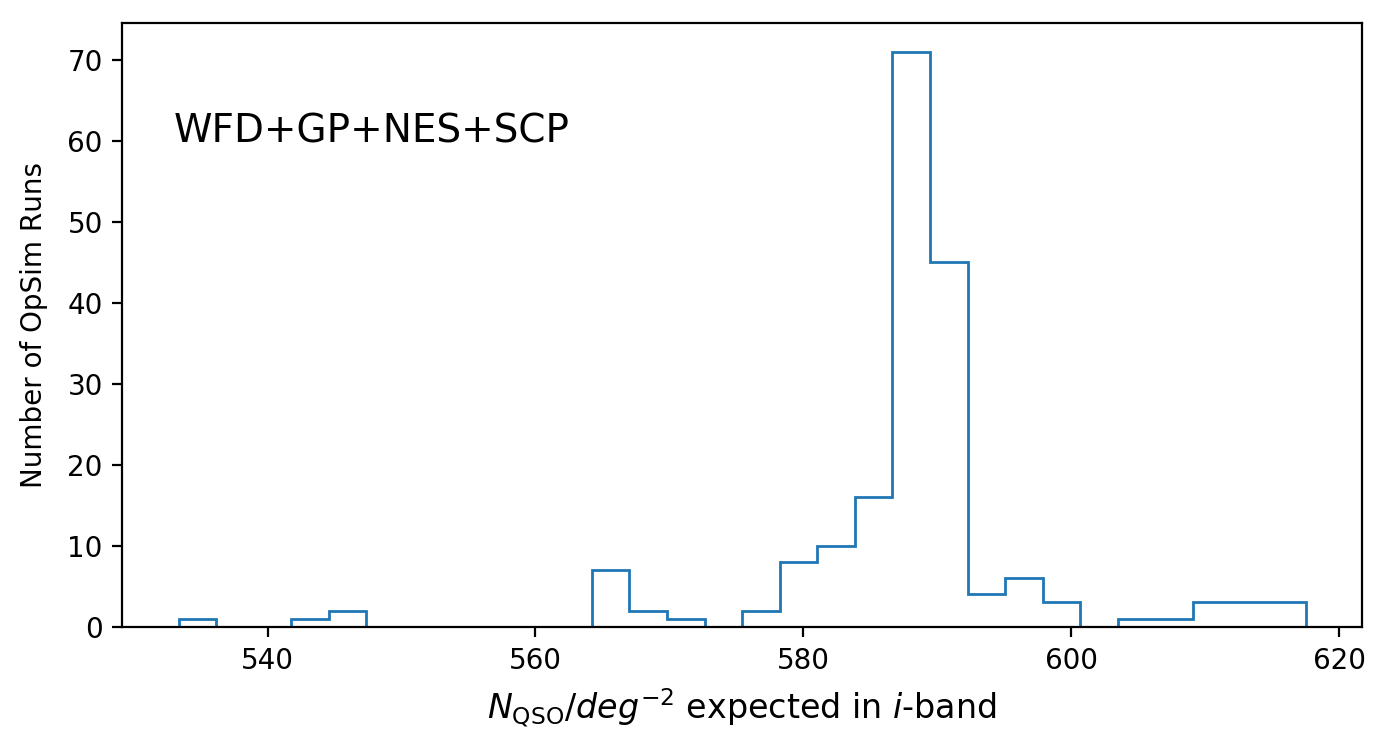

In [16]:
for filter in filters:
    xlabel = r'$N_{\rm QSO}/deg^{-2}$ expected in $'+filter+r'$-band'
    survey_label = "WFD+GP+NES+SCP"
    plot_OpSims_Nqso_hist_v2(filter, dens, xlabel=xlabel, 
                             datamin=None, datamax=None, bins=30, figsize=(8,4),
                             survey_label=survey_label)
    plt.savefig(plots_folder+"/qso_density_{}.png".format(filter))

In [17]:
median_depth = dict()
for filter in filters:
    zmin = 0.3
    zmax = np.min([6.7, (lam_eff['LSST'+filter]/(912.*u.AA)).to(1.).value])
    for k, run in enumerate(dbRuns):
        for run_key in bundleDicts[run].keys():
            if run_key[1][-1]==filter:
                Key = run_key
                break
        mask  = bundleDicts[run][Key].metricValues.mask
        mlim5 = bundleDicts[run][Key].metricValues[~mask]
        filter = Key[1][-1]
        if filter not in median_depth:
            median_depth[filter] = np.zeros(len(dbRuns))
        median_depth[filter][k] = np.median(mlim5)

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


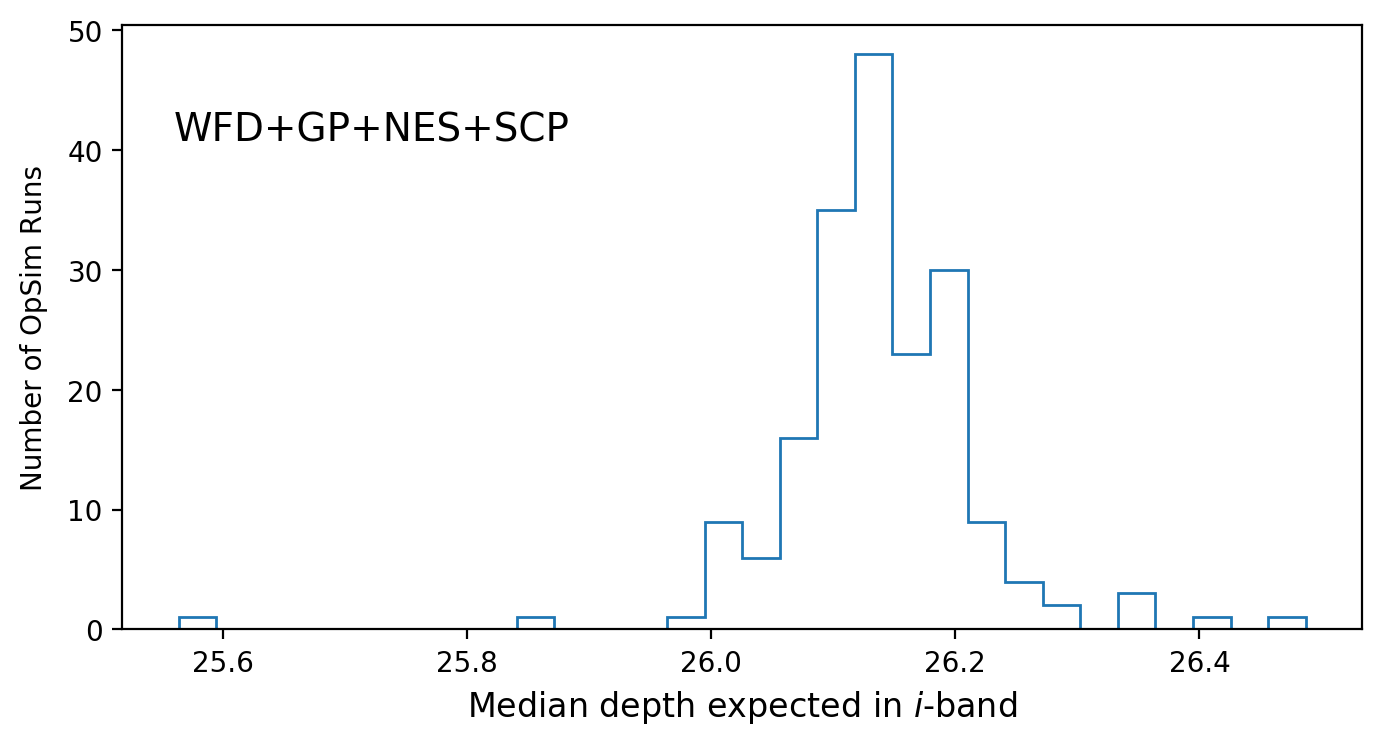

In [18]:
for filter in filters:
    xlabel = r'Median depth expected in $'+filter+r'$-band'
    survey_label = "WFD+GP+NES+SCP"
    plot_OpSims_Nqso_hist_v2(filter, median_depth, xlabel=xlabel, 
                             datamin=None, datamax=None, bins=30, figsize=(8,4), 
                             survey_label=survey_label)
    #plt.savefig(plots_folder+"/qso_density_{}.png".format(filter))